# Augmentation

Augmentation for MRI has its limitaions. The model needs to recognize a specific pattern or shape that is common for each class and it can be disturbed by the augmentation. I will fit the models using augmented images from ImageDataGenerator and Albumentations.

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow import cast, image, numpy_function
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import resnet50
from tensorflow.image import grayscale_to_rgb
from tensorflow import convert_to_tensor
from tensorflow.keras.utils import to_categorical

import albumentations as A
import cv2
from os import listdir
from sklearn.model_selection import train_test_split
import functions
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(18)

In [27]:
# Set image size
image_size = 240

# Path to Alzheimer's data
al_path_train = '../data/alzheimer/train'
al_path_test = '../data/alzheimer/test'

# Path to Brain Tumor data
bt_path_train = '../data/brain_tumor/train'
bt_path_test = '../data/brain_tumor/test'

In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lr = 0.001
    if epoch > 10:
        lr *= 0.1
    return lr

scheduler = LearningRateScheduler(lr_schedule)
optimizer = keras.optimizers.Adam()


In [3]:
# ImageDataGenerator
datagen = ImageDataGenerator(
        brightness_range=[0.2,1.2],
        width_shift_range=0.05,
        height_shift_range=0.05, 
        horizontal_flip=True,
        validation_split=0.20) 

Found 5121 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


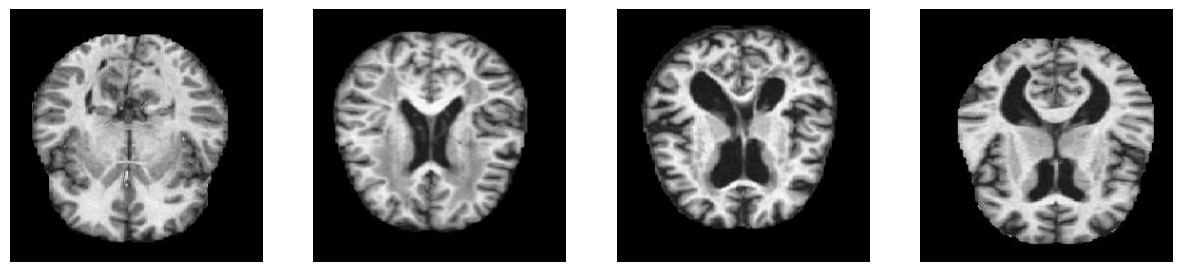

In [6]:
al_train_dg = datagen.flow_from_directory(
                  directory=al_path_train,
                  target_size=(image_size, image_size), # resize to this size
                  color_mode="grayscale", # for coloured images
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=18 # to make the result reproducible
                  )

al_val_dg = datagen.flow_from_directory(
                  directory=al_path_train,
                  target_size=(image_size, image_size), # resize to this size
                  color_mode="grayscale", # for coloured images
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=18,
                  shuffle=True,
                  subset='validation'
                  )


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
    # convert to unsigned integers for plotting
    image = next(al_train_dg)[0].astype('uint8')

    # changing size for plotting the image
    image = np.squeeze(image)

    # plot raw pixel data
    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')

In [7]:
es = EarlyStopping(patience = 5)

model = Sequential()


model.add(layers.Input(shape=(image_size, image_size, 1)))
model.add(layers.Rescaling(1./255))

#First Convolution
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#Second Convolution
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#Flatten
model.add(Flatten())
# Fully Connected
model.add(Dense(32, activation = 'relu'))
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h = model.fit(al_train_dg, validation_data = al_val_dg, steps_per_epoch=len(al_train_dg) / 32, epochs=50, callbacks = [scheduler])

Epoch 1/50
160/160 [==============================] - 15s 88ms/step - loss: 1.4372 - accuracy: 0.4472 - val_loss: 1.2433 - val_accuracy: 0.5005
Epoch 2/50
160/160 [==============================] - 13s 83ms/step - loss: 1.1464 - accuracy: 0.4037 - val_loss: 1.0429 - val_accuracy: 0.5005
Epoch 3/50
160/160 [==============================] - 13s 83ms/step - loss: 1.0644 - accuracy: 0.5280 - val_loss: 1.0590 - val_accuracy: 0.5005
Epoch 4/50
160/160 [==============================] - 14s 87ms/step - loss: 1.1192 - accuracy: 0.4969 - val_loss: 1.1659 - val_accuracy: 0.3500
Epoch 5/50
160/160 [==============================] - 13s 80ms/step - loss: 1.0524 - accuracy: 0.4596 - val_loss: 1.0411 - val_accuracy: 0.5005
Epoch 6/50
160/160 [==============================] - 13s 84ms/step - loss: 0.9918 - accuracy: 0.5280 - val_loss: 1.0414 - val_accuracy: 0.5005
Epoch 7/50
160/160 [==============================] - 13s 81ms/step - loss: 1.0362 - accuracy: 0.4783 - val_loss: 1.0372 - val_accuracy:

# Brain Tumor

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


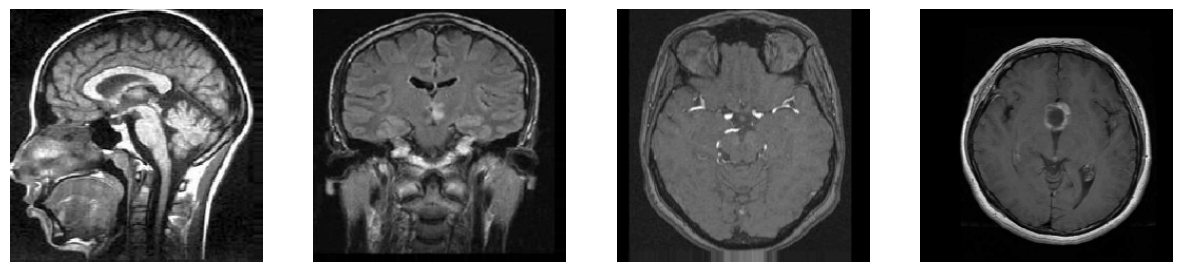

In [8]:
bt_train_dg = datagen.flow_from_directory(
                  directory=bt_path_train,
                  target_size=(image_size, image_size), # resize to this size
                  color_mode="grayscale", # for coloured images
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=18,
                  shuffle=True,
                  subset='training'
                  )

bt_val_dg = datagen.flow_from_directory(
                  directory=bt_path_train,
                  target_size=(image_size, image_size), # resize to this size
                  color_mode="grayscale", # for coloured images
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=18,
                  shuffle=True,
                  subset='validation'
                  )

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
    # convert to unsigned integers for plotting
    image = next(bt_train_dg)[0].astype('uint8')

    # changing size for plotting the image
    image = np.squeeze(image)

    # plot raw pixel data
    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')

In [9]:
es = EarlyStopping(patience = 5)
model = Sequential()
model.add(layers.Input(shape=(image_size, image_size, 1)))
model.add(layers.Rescaling(1./255))
model.add(Conv2D(64,kernel_size = (2,2),strides = (1,1),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(64,kernel_size = (2,2),strides = (1,1),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(128,kernel_size = (2,2),strides = (1,1),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(256,kernel_size = (2,2),strides = (1,1),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(512,kernel_size = (2,2),strides = (1,1),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256, activation="linear"))
model.add(Dense(4, activation='softmax'))
# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h = model.fit(bt_train_dg, validation_data = bt_val_dg, steps_per_epoch=len(bt_train_dg) / 32, epochs=50, callbacks = [es])

Epoch 1/50
71/71 [==============================] - 13s 177ms/step - loss: 1.4078 - accuracy: 0.3611 - val_loss: 1.3681 - val_accuracy: 0.2880
Epoch 2/50
71/71 [==============================] - 14s 191ms/step - loss: 1.3610 - accuracy: 0.2083 - val_loss: 1.3550 - val_accuracy: 0.2897
Epoch 3/50
71/71 [==============================] - 13s 176ms/step - loss: 1.3582 - accuracy: 0.3333 - val_loss: 1.3782 - val_accuracy: 0.2880
Epoch 4/50
71/71 [==============================] - 14s 197ms/step - loss: 1.3538 - accuracy: 0.3194 - val_loss: 1.3508 - val_accuracy: 0.2880
Epoch 5/50
71/71 [==============================] - 13s 188ms/step - loss: 1.4153 - accuracy: 0.2222 - val_loss: 1.3560 - val_accuracy: 0.2880
Epoch 6/50
71/71 [==============================] - 14s 190ms/step - loss: 1.3717 - accuracy: 0.2361 - val_loss: 1.3521 - val_accuracy: 0.2880
Epoch 7/50
71/71 [==============================] - 14s 192ms/step - loss: 1.3713 - accuracy: 0.2917 - val_loss: 1.3540 - val_accuracy: 0.2862

For Brain Tumors, augmentation works even worse than for Alzheimer's. I will try Albumentations and add the augmented images to the training set to increase the number of images to train on. 

## Albumentations 

In [23]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.25)
])

In [25]:
def ald_augmentation(X_train, y_train):
    # Make a copy of the training set and augment it
    X_aug = X_train.copy()
    for image in X_aug:
        image = transform(image=image)['image']
        image = convert_to_tensor(image[:,:,:1])
        image = grayscale_to_rgb(image, name=None)
    # Add augmented data to training set
    X_train = X_train + X_aug
    y_train = y_train + y_train
    # Prepare data for Tensorflow model
    X_train = np.array(X_train, dtype='float32')
    y_train = to_categorical(y_train, num_classes=4, dtype='float32')
    return X_train, y_train

In [12]:
def alb_prepare_data(path):
    X = []
    y = []

    for num_label, label in enumerate(listdir(path)):
            # Change each image and append to X and y
            for image in listdir(f'{path}/{label}'):
                if '.jpg' in image:
                    image = cv2.imread(f'{path}/{label}/{image}')  
                    image = cv2.resize(image, (256, 256))

                    X.append(image)
                    y.append(num_label)

    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=18, stratify=y) 

    # Change Validation set for TensorFlow models
    for image in X_val:
        image = convert_to_tensor(image[:,:,:1])
        # Make image RGB for pre-trained models
        image = grayscale_to_rgb(image, name=None)

    X_val = np.array(X_val, dtype='float32')
    y_val = to_categorical(y_val, num_classes=4, dtype='float32')
    # Apply augmentation on trainig set 
    X_rain, y_train = ald_augmentation(X_train, y_train)
    return X_train, X_val, y_train, y_val

### Alzheimer's

In [26]:
X_train, X_val, y_train, y_val = alb_prepare_data(al_path_train)

In [32]:
X_test, y_test = functions.read_grey_images_to_rgb(al_path_train, train_test = False)

In [163]:
# This model gave better scores on non augmented data
rn_model = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax"
)

In [164]:
# Freeze layers
for layer in rn_model.layers:
    layer.trainable = False

In [165]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

model = Sequential()

model.add(rn_model)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_rn = model.fit(X_train, y_train, validation_data = (X_val, y_val), steps_per_epoch=len(X_train) / 32, epochs=50, callbacks = [es])

Epoch 1/50
240/240 [==============================] - 1302s 5s/step - loss: 2.9683 - accuracy: 0.7116 - val_loss: 1.2450 - val_accuracy: 0.8361
Epoch 2/50
240/240 [==============================] - 1283s 5s/step - loss: 0.5897 - accuracy: 0.9126 - val_loss: 0.7272 - val_accuracy: 0.8884
Epoch 3/50
240/240 [==============================] - 1857s 8s/step - loss: 0.1143 - accuracy: 0.9732 - val_loss: 0.9801 - val_accuracy: 0.8720
Epoch 4/50
240/240 [==============================] - 1888s 8s/step - loss: 0.1620 - accuracy: 0.9677 - val_loss: 4.2488 - val_accuracy: 0.6612
Epoch 5/50
240/240 [==============================] - 1895s 8s/step - loss: 0.9812 - accuracy: 0.9299 - val_loss: 2.5606 - val_accuracy: 0.8056
Epoch 6/50
240/240 [==============================] - 1873s 8s/step - loss: 0.1938 - accuracy: 0.9693 - val_loss: 1.0772 - val_accuracy: 0.8946
Epoch 7/50
240/240 [==============================] - 1827s 8s/step - loss: 0.6702 - accuracy: 0.9504 - val_loss: 1.2138 - val_accuracy:

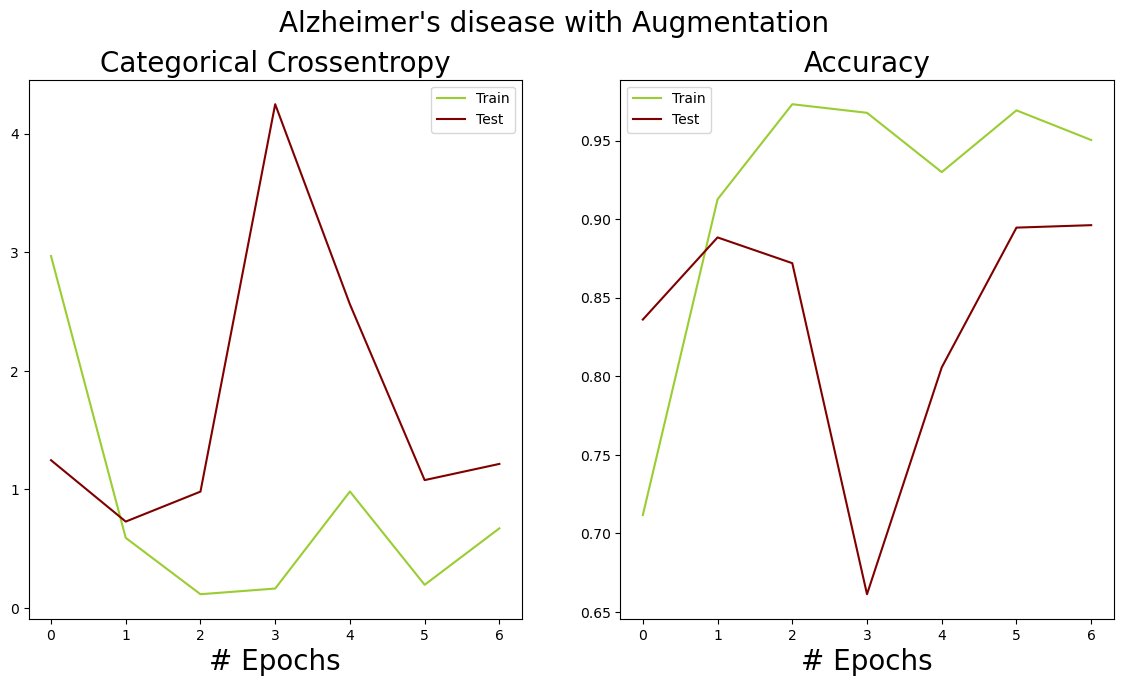

In [170]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_rn, 'Alzheimer\'s disease with Augmentation')

Accuracy_score: 0.8884 



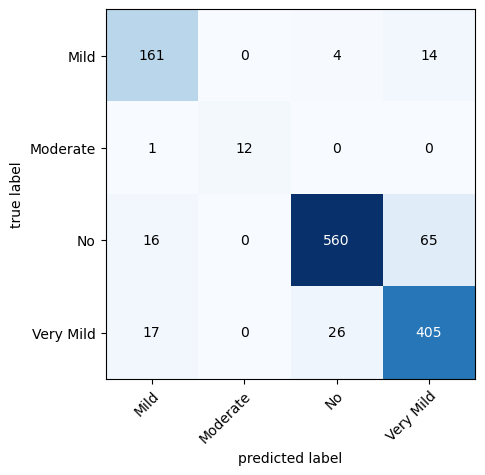

In [169]:
# Testing set Plot Confusion Matrix and print Accuracy
acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Accuracy_score: 0.6427 



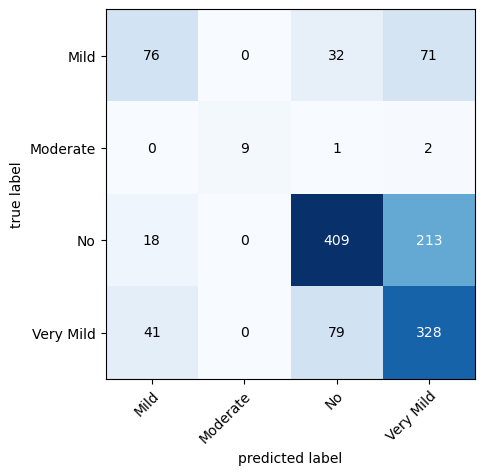

In [174]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Augmentation did not improve the accuracy of the model. Without Augmentation accuracy was 0.67

### Brain Tumor

In [33]:
X_train, X_val, y_train, y_val = alb_prepare_data(bt_path_train)

In [34]:
X_test, y_test = functions.read_grey_images_to_rgb(bt_path_train, train_test = False)

---

I have tried ImageDataGenerator and Albumentations neither of them imroved the scores of the models.